# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [9]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [10]:
# Define transforms
## YOUR CODE HERE ##
t = transforms.Compose([transforms.ToTensor()])


# Create training set and define training dataloader
## YOUR CODE HERE ##
train_data = torchvision.datasets.MNIST('./data', train=True, download=True, transform=t)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = torchvision.datasets.MNIST('./data', train=False, download=True, transform=t)

num_workers=0

train_length = len(train_data)
indices = list(range(train_length))

# define samplers for obtaining training and validation batches
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, sampler=train_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, num_workers=0)
     

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

Tensors are efficient for numerical computations and are well-suited for deep learning algorithms. This helps to improve the convergence and stability of neural network models during training. These are the reasons I have used the ToTensor() transformation.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [11]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

The size of the input image is 28x28 pixels. 

7


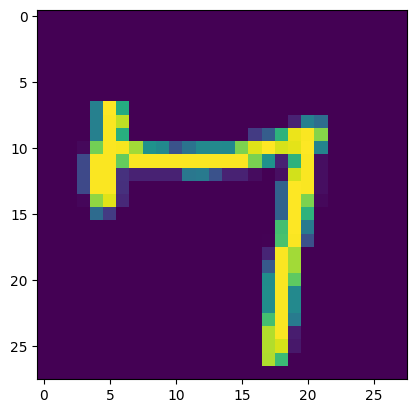

4


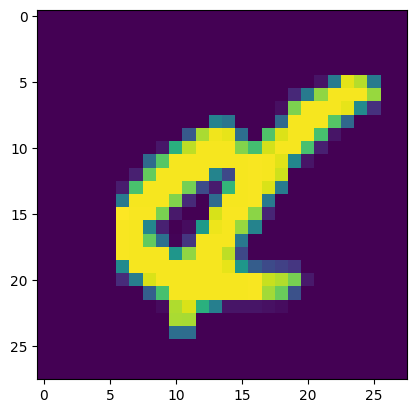

7


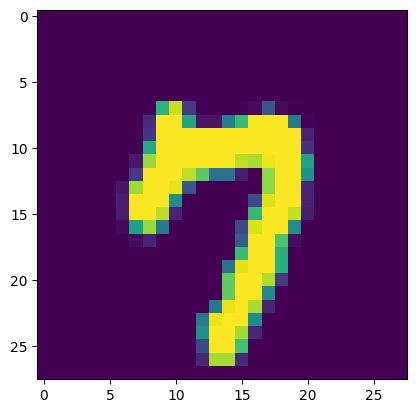

9


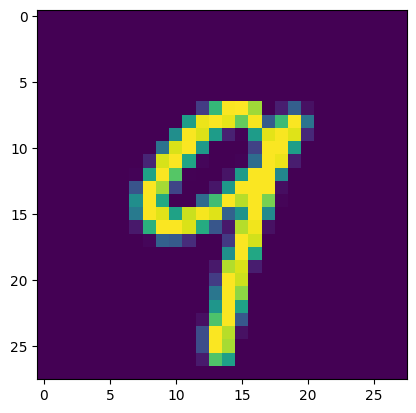

3


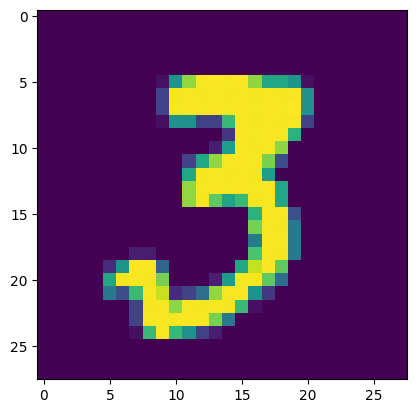

Batch shape:  torch.Size([20, 1, 28, 28]) 
Image Shape torch.Size([1, 28, 28])


In [12]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)
a = next(iter(train_loader))[0]
print("Batch shape: ",a.shape,"\nImage Shape",a[0].shape)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [13]:
## YOUR CODE HERE ##

class convNet(nn.Module):
  def __init__(self):
    super(convNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)


    self.fc1=nn.Linear(7*7*32,512)
    self.fc2=nn.Linear(512,256)
    self.out=nn.Linear(256,10)
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,7*7*32)
    x = self.dropout(x)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.dropout(F.relu(self.fc2(x)))
    x=self.out(x)
    return x

mod = convNet()

print(mod)

convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [14]:
## YOUR CODE HERE ##

criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(mod.parameters(),lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [16]:
## YOUR CODE HERE ##
def trainNet(model):

    loss_keeper = {'train':[]}
    epochs = 25

    for epoch in range(epochs):
        train_loss=0.0

        model.train()
        for images,labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        loss_keeper['train'].append(train_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}")
        
    return(loss_keeper)

mod_loss=trainNet(mod)


Epoch : 1	Training Loss : 0.022216992607752215

Epoch : 2	Training Loss : 0.021079758225709927

Epoch : 3	Training Loss : 0.019226954055189063

Epoch : 4	Training Loss : 0.018609203983945388

Epoch : 5	Training Loss : 0.018584059795256378

Epoch : 6	Training Loss : 0.016037145834284356

Epoch : 7	Training Loss : 0.01738833651444002

Epoch : 8	Training Loss : 0.015915603330266797

Epoch : 9	Training Loss : 0.014720017291791593

Epoch : 10	Training Loss : 0.014949406685754826

Epoch : 11	Training Loss : 0.015785248640200922

Epoch : 12	Training Loss : 0.015288725940527506

Epoch : 13	Training Loss : 0.016081317717940077

Epoch : 14	Training Loss : 0.013715129860209408

Epoch : 15	Training Loss : 0.014971896465229369

Epoch : 16	Training Loss : 0.013070258476424849

Epoch : 17	Training Loss : 0.013076905222649614

Epoch : 18	Training Loss : 0.013779629755513957

Epoch : 19	Training Loss : 0.014542264335763116

Epoch : 20	Training Loss : 0.013525091582171451

Epoch : 21	Training Loss : 0.

Plot the training loss (and validation loss/accuracy, if recorded).

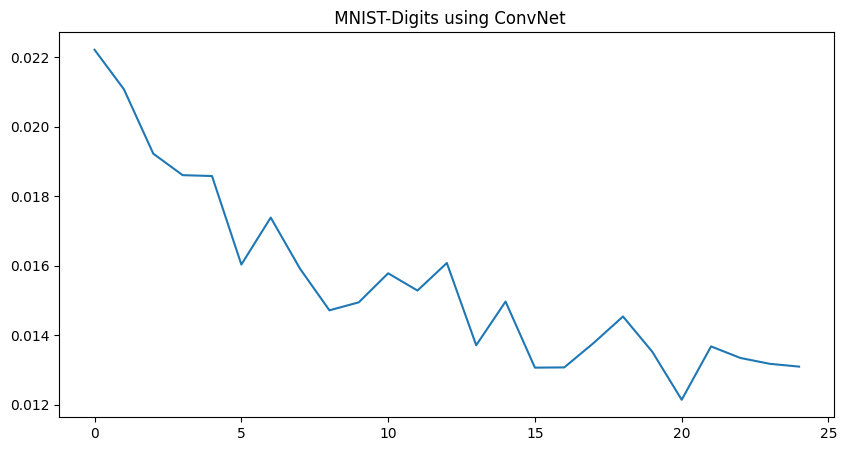

In [17]:
## YOUR CODE HERE ##
title = ' MNIST-Digits using ConvNet'
plt.figure(figsize=(10,5))
plt.title(title)
plt.plot(mod_loss['train'],label="Training Loss")
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [18]:
## YOUR CODE HERE ##
def test(model):
    correct = 0
    test_loss = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()

    for images,labels in test_loader:
        output = model(images)
        loss = criterion(output,labels)
        test_loss += loss.item()
        _, pred = torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(20):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    test_loss = test_loss/len(test_loader)
    print(f"Correctly predicted per class : {class_correct} \n Total correctly predicted : {sum(class_correct)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {i} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nTest Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")

  
     
test(mod)

Correctly predicted per class : [979.0, 1131.0, 1024.0, 1003.0, 971.0, 887.0, 945.0, 1019.0, 963.0, 996.0] 
 Total correctly predicted : 9918.0

Test Accuracy of class 0 : 99.89795918367346% where 979 of 980 were predicted correctly
Test Accuracy of class 1 : 99.64757709251101% where 1131 of 1135 were predicted correctly
Test Accuracy of class 2 : 99.2248062015504% where 1024 of 1032 were predicted correctly
Test Accuracy of class 3 : 99.3069306930693% where 1003 of 1010 were predicted correctly
Test Accuracy of class 4 : 98.87983706720978% where 971 of 982 were predicted correctly
Test Accuracy of class 5 : 99.43946188340807% where 887 of 892 were predicted correctly
Test Accuracy of class 6 : 98.64300626304802% where 945 of 958 were predicted correctly
Test Accuracy of class 7 : 99.12451361867704% where 1019 of 1028 were predicted correctly
Test Accuracy of class 8 : 98.870636550308% where 963 of 974 were predicted correctly
Test Accuracy of class 9 : 98.71159563924678% where 996 of 

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!


I tried various learning rates, as well as the sgd optimizer. Using a lower learning rate gives better results, with more epochs seems to be the best way, but I dont have the compute power for it.

## Saving your model
Using `torch.save`, save your model for future loading.

In [19]:
## YOUR CODE HERE ##
torch.save(mod.state_dict(), "./model.pt")